# Gathering the Data

In [124]:
import numpy as np
import pandas as pd

In [125]:
import os
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(filename)

test.csv
train.csv


# Importing Relevant Files

In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk.tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [127]:
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from tqdm import tqdm

In [128]:
df_train= pd.read_csv('data/train.csv')
df_test=pd.read_csv('data/test.csv')

# Exploratory Data Analysis

In [177]:
print('Train: {} rows, {} columns'.format(df_train.shape[0],df_train.shape[1]))
print('Test: {} rows, {} columns'.format(df_test.shape[0],df_test.shape[1]))

Train: 7613 rows, 6 columns
Test: 3263 rows, 4 columns


In [182]:
tokenizer = nltk.tokenize.TreebankWordTokenizer()

In [183]:
df_train['tokenized'] = df_train['text'].apply(tokenizer.tokenize)

In [184]:
df_train.sample(1)

,id,keyword,location,text,target,tokenized
5523,7878,quarantined,NaN,Alabama firefighters quarantined after possibl...,1,"[Alabama, firefighters, quarantined, after, po..."


Text(0.5, 1.0, 'Disaster Tweets')

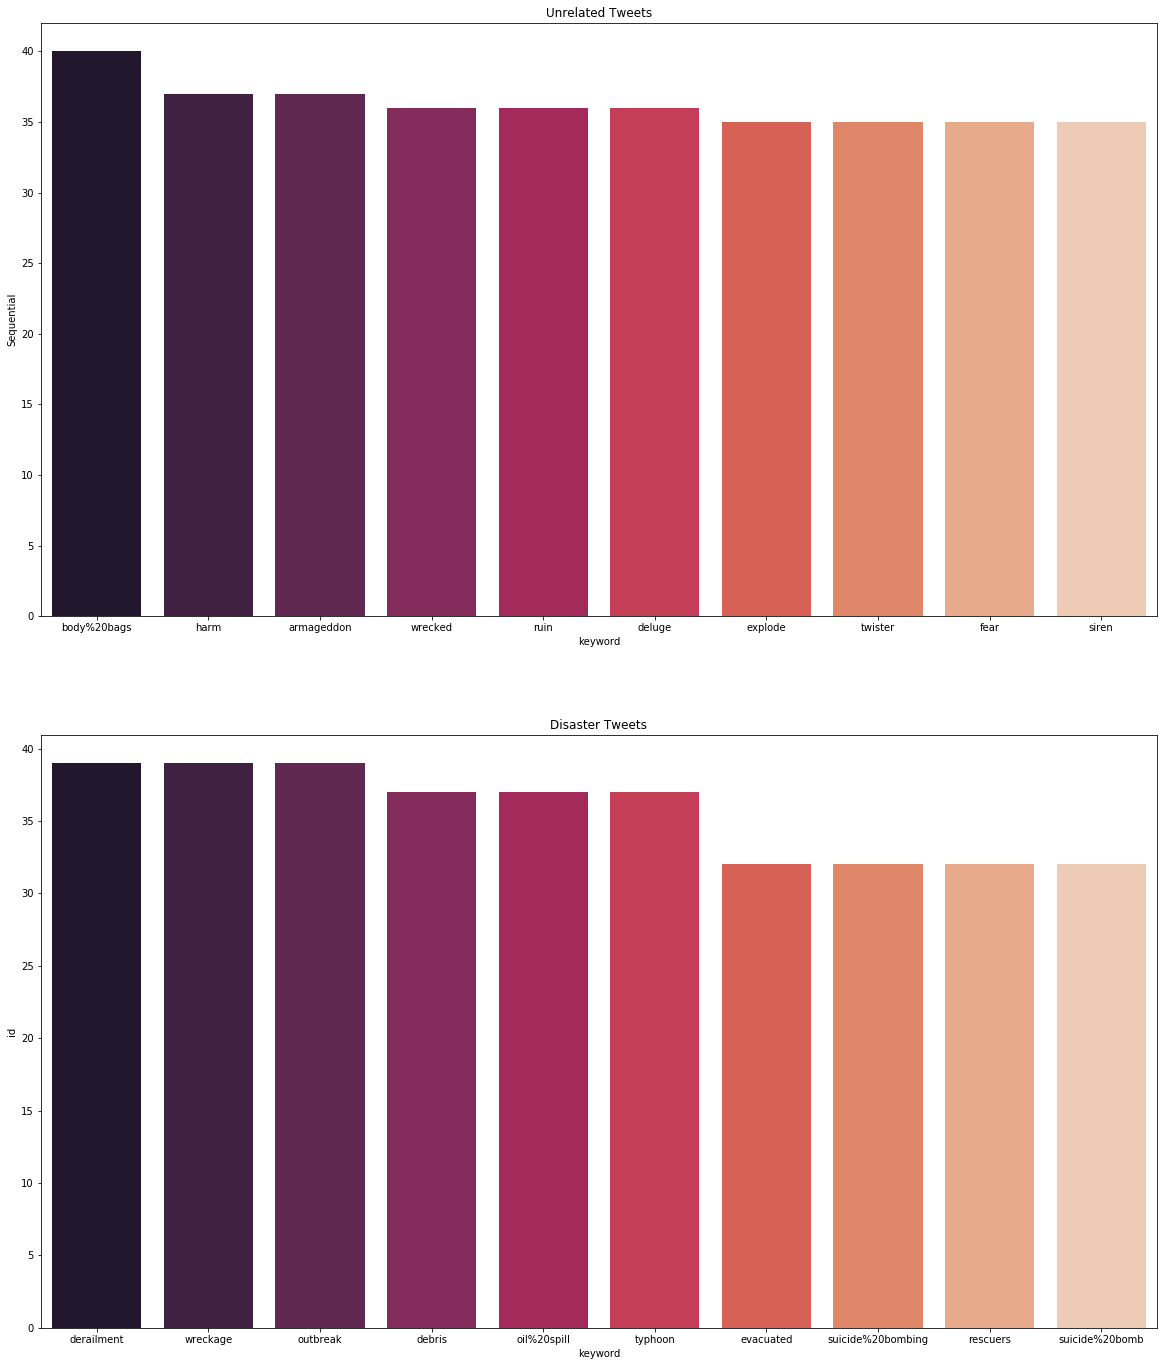

In [176]:
# Plotting most common keywords
fig,(ax1,ax2)= plt.subplots(2,1,figsize=(20,24))

temp = pd.DataFrame(df_train[df_train['target']==0].groupby('keyword')['id'].count())
temp.sort_values('id',ascending=False,inplace=True)
sns.barplot(temp.index[:10],temp['id'][:10],palette="rocket",ax=ax1).set_title('Unrelated Tweets')
ax1.set_ylabel("Sequential")


temp = pd.DataFrame(df_train[df_train['target']==1].groupby('keyword')['id'].count())
temp.sort_values('id',ascending=False,inplace=True)
sns.barplot(temp.index[:10],temp['id'][:10],palette="rocket",ax=ax2).set_title('Disaster Tweets')

> Top disaster tweets keywords :
- Derailment
- Wreckage
- Outbreak

> Top unrelated tweet keywords:
- Body Bags
- Harm
- Armageddon

In [185]:
#https://www.analyticsvidhya.com/blog/2018/07/hands-on-sentiment-analysis-dataset-python/
def hashtagextract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
    return hashtags

HT_regular = hashtagextract(df_train['text'][df_train['target'] == 0])

# extracting hashtags from disaster tweets
HT_disaster = hashtagextract(df_train['text'][df_train['target'] == 1])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_disaster = sum(HT_disaster,[])

Text(0.5, 1.0, 'Disaster Tweets')

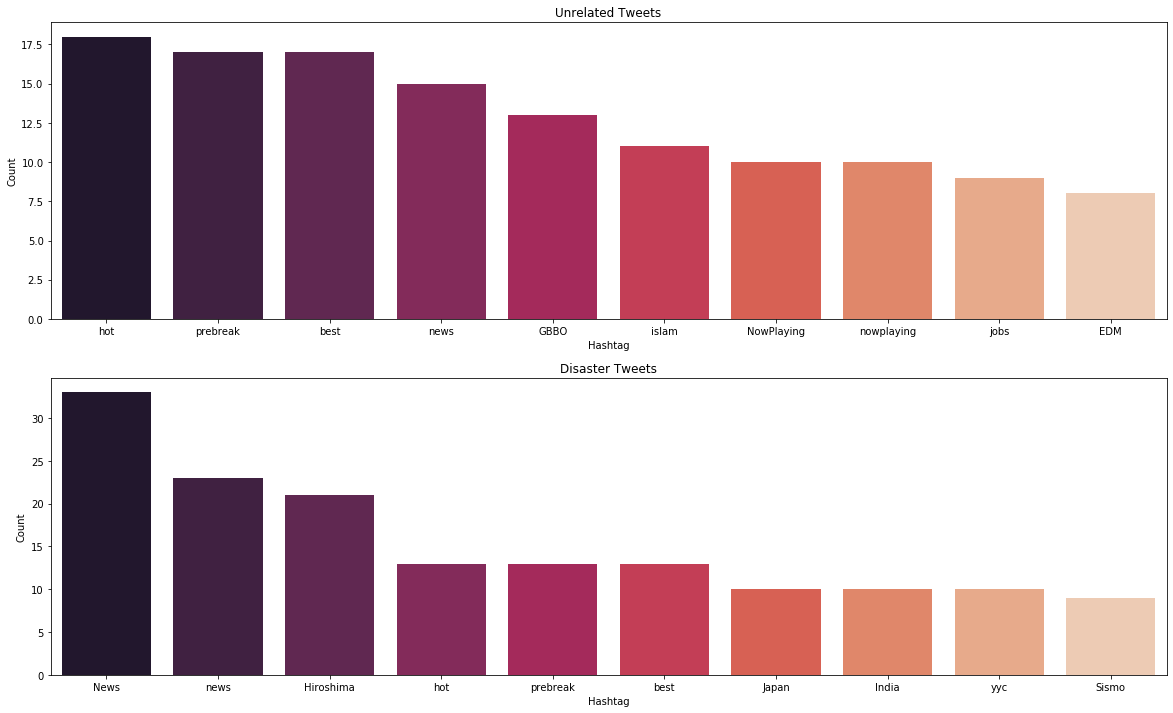

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

In [186]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(20,12))

a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# top 10 most common hashtags with negative label     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
sns.barplot(data=d, x= "Hashtag", y = "Count",ax=ax1, palette="rocket").set_title('Unrelated Tweets')

a = nltk.FreqDist(HT_disaster)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# top 10 most common hashtags with positive label     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
sns.barplot(data=d, x= "Hashtag", y = "Count",ax=ax2, palette="rocket").set_title('Disaster Tweets')

## Data Cleaning Process

In [187]:
df = df_train.append(df_test,ignore_index=True, sort=True)

In [188]:
# function for removing particular patterns such as links, urls etc using regex
def rem_pattern(input_txt, pattern):
    reg_obj = re.compile(pattern)
    ip_txt = reg_obj.sub(r'', input_txt)
        
    return ip_txt   

In [191]:
#for twitter handles
df['text'] = df['text'].apply(lambda x: rem_pattern(x,"@[\w]*"))

In [192]:
#for url 
df['text'] = df['text'].apply(lambda x: rem_pattern(x,'https?://\S+|www\.\S+'))
df['text'] = df['text'].apply(lambda x: rem_pattern(x,'<.*?>'))

In [193]:
#for punctuation, stopwords, characters and numbres

df['text'] = df['text'].apply(lambda x: rem_pattern(x,"[^a-zA-Z#]"))

In [194]:
#Setting stopwords
stop=set(stopwords.words('english'))

In [195]:
# function for removing stopwords
def rem_stop_words(text):
    wt = word_tokenize(text) 
    sentence = [w for w in wt if not w in stop] 
    tweet = ' '.join(filtered_sentence)
    return tweet

In [196]:
df['text'] = df['text'].apply(lambda x: remove_stop_words(x))

## NLP Preprocessing - Tokenisation and Stemming

In [197]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [198]:
def tokenize_stem(text):
    
    tw = word_tokenize(text)
    stem_words =[]
    for i in tw:
        word = lemmatizer.lemmatize(i)
        stem_words.append(word)
        
    final_tweet = ' '.join(stem_words)
    
    return final_tweet

In [199]:
df['text'] = df['text'].apply(lambda x: tokenize_stem(x))

In [200]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2,stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df['text'])

In [201]:
tfidf.shape

(10876, 628)

In [202]:
Final_train = tfidf[:7613,:]
Final_test = tfidf[7613:,:]

In [203]:
Final_train.shape, Final_test.shape

((7613, 628), (3263, 628))

## Model 1 - Logistic Regression

In [204]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [205]:
xtrain = Final_train[:5331]
xvalid = Final_train[5331:]
ytrain = df[:5331]['target']
yvalid = df[5331:7613]['target']

parameter = {'solver':['liblinear','lbfgs'],
            'max_iter':[200,400]}

Logis_clf = LogisticRegression()

lreg = GridSearchCV(Logis_clf, param_grid = parameter, cv = 3, verbose=True, n_jobs=-1)
lreg.fit(xtrain, ytrain) # training the model

prediction = lreg.predict_proba(xvalid) 

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   28.3s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   28.3s finished


ROC AUC=0.815


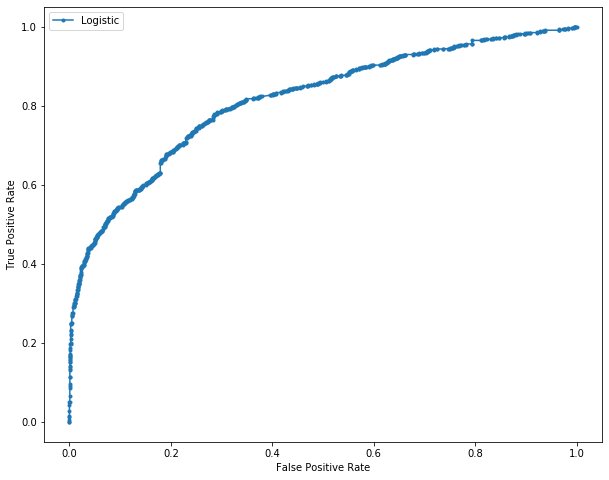

In [114]:
from sklearn.metrics import roc_auc_score,roc_curve,f1_score, confusion_matrix


# keep probabilities for the positive outcome only
prob = prediction[:, 1]
auc = roc_auc_score(yvalid, prob)


print('ROC AUC=%.3f' % (auc))

fpr, tpr, _ = roc_curve(yvalid, prob)

# plot the roc curve for the model
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

> Observed AUC = 0.815

### Scoring Logistic Regression 

In [115]:
prediction_int = prediction[:,1] >= 0.35
prediction_int = prediction_int.astype(np.int)
f1score = f1_score(yvalid,prediction_int)
print('F1 Score : %.3f' %(f1score))
conf = confusion_matrix(yvalid,prediction_int)
print(conf)

F1 Score : 0.698
[[683 590]
 [152 857]]


### Prediction on Final Submission Test Data

In [206]:
prediction = lreg.predict_proba(Final_test) # predicting on the test set

prediction_int = prediction[:,1] >= 0.35
prediction_int = prediction_int.astype(np.int)

##  Model 2: Naive Bayes

In [207]:
from sklearn.naive_bayes import MultinomialNB

NB = MultinomialNB()
NB.fit(xtrain, ytrain)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

### Scoring Naive Bayes

In [208]:
pred_naive = NB.predict(xvalid)
conf = confusion_matrix(yvalid, pred_naive)
print(conf)

f1score = f1_score(yvalid,pred_naive)
print('F1 Score : %.3f' %(f1score))

pred_naive_test = NB.predict(Final_test)
pred_naive_test = pred_naive_test.astype(int)

[[1256   17]
 [ 957   52]]
F1 Score : 0.096


## Model 3: SVM

In [211]:
import sklearn.svm as svm
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}
SVM_Model = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=3, n_jobs=-1).fit(xtrain, ytrain)

In [212]:
SVM_valid = SVM_Model.predict(xvalid)
SVM_valid = SVM_valid.astype(int)

### Scoring SVM

In [213]:
cm = confusion_matrix(yvalid, SVM_valid)
print(cm)

f1score = f1_score(yvalid,SVM_valid)
print('F1 Score : %.3f' %(f1score))

[[1254   19]
 [ 955   54]]
F1 Score : 0.100


### Prediction on Final Test Set 

In [214]:
SVM_valid_f = SVM_Model.predict(Final_test)
SVM_valid_f = SVM_valid_f.astype(int)

## Ensemble Learning by Bagging ##

In [122]:
temp = []
for i in range(0, 3263):
    temp.append(prediction_int[i] + pred_SVM_valid_f[i] + pred_naive_test[i])
    temp[i] = temp[i]/3
    if(temp[i]<0.5):
        temp[i] = 0
    else:
        temp[i] = 1

##  Final Submission File

In [53]:
temp = np.array(pred_naive_test)
test_df['target'] = temp

Final_submission= test_df[['id','target']]
Final_submission.to_csv('submission.csv',index=False)